# Fear Greed/RSI and Alpaca Markets

# Set Up Training Data

In [66]:
# Get Data from Yahoo and Fear and Greed
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
from finta import TA

In [67]:
# Yahoo! Financial Data
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

hist = cc.history(start=f"{start}", end=f"{end}")

# just close column
historical = pd.DataFrame(hist)
historical_close = historical.drop(['Open','High', 'Low','Volume', 'Dividends', 'Stock Splits'], axis=1)


In [68]:
# Get Fear and Greed Data 
import requests
r = requests.get('https://api.alternative.me/fng/?limit=0')

fg_df = pd.DataFrame(r.json()['data'])

    # convert 'value' to int
fg_df.value = fg_df.value.astype(int)

    # convert time format to datetime
fg_df.timestamp = pd.to_datetime(fg_df.timestamp, unit='s' )

    # set date as index
fg_df.set_index('timestamp', inplace=True)

    # drop all columns except 'value'
fg_df = fg_df.drop(['value_classification', 'time_until_update'], axis=1)

# flip oldest data to the top
fg_df = fg_df[::-1]

    # convert date format to match 'df close'
fg_df.index = pd.to_datetime(fg_df.index).tz_localize('Etc/UCT')




In [69]:
# Combined both Financial and Fear and Greed Data

# rename index to match fg_df
historical.index.name = 'timestamp'

# combine historical price data with historical fear and greed
combined_df = pd.concat([fg_df, historical_close], axis=1, join='outer')

combined_df_ = combined_df.copy()

# add 'change' column using pct_change on 'Close'
combined_df_['change'] = combined_df_['Close'].pct_change()


In [70]:
# algorithm to trade on fear and greed data
combined_df_['Signal'] = 0

# short when f&g is over 94 (f&g > 94 = -1)
for index, row in combined_df_.iterrows():
    if row['value'] >= 95:
        combined_df_.loc[index, 'Signal'] = -1.0

# long when f&g is over 45 and under 94 (93 > f&g > 45 = 1)
    elif row['value'] >= 46:
        combined_df_.loc[index, 'Signal'] = 1.0

# short when f&g is over 24 and less than 46 (46 > f&g > 24 = -1)
    elif row['value'] >= 25:
        combined_df_.loc[index, 'Signal'] = -1.0
# hold stables under 25 (f&g < 25 = 0.0)
    elif row['value'] < 25:
        combined_df_.loc[index, 'Signal'] = 0

combined_df_ = combined_df_.dropna()
combined_df_

,value,Close,change,Signal
timestamp,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,0
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,-1
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,0
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,0
...,...,...,...,...
2023-01-19 00:00:00+00:00,45.0,1552.556519,0.024447,-1
2023-01-20 00:00:00+00:00,51.0,1659.754150,0.069046,1
2023-01-21 00:00:00+00:00,53.0,1627.118164,-0.019663,1


# XGB Boost ML Model

In [71]:
#XGB:
import pandas_ta as pa
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config 
set_config(transform_output = 'pandas')


m = combined_df_.copy()
m['RSI'] = pa.rsi(m.Close, length=16)

# fill in na with 0
m.fillna(0, inplace=True)

# change -1 to 2 for short selling
m[m<0] = 2

In [72]:
# Identify Features and Target
X = m.drop(["Signal"], axis=1).shift().dropna()
y = m["Signal"][1:].copy()

In [73]:
#Create Transformer Pipelines

categorical_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),])
numeric_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())])

cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

full_processor = ColumnTransformer(transformers=[("numeric", numeric_pipeline, num_cols),("categorical", categorical_pipeline, cat_cols)])



In [74]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


xgb_cl = xgb.XGBClassifier(colsample_bylevel=1, gamma=1, learning_rate= 1)

# Apply preprocessing
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(y.values.reshape(-1, 1))


# Split the data to train and Test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, stratify=y_processed, random_state=1)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
pred = xgb_cl.predict(X_test)


# Score
xgb_testing_report = classification_report(y_test, pred)
print(xgb_testing_report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       123
           1       0.89      0.93      0.91       162
           2       0.81      0.78      0.79       169

    accuracy                           0.85       454
   macro avg       0.84      0.85      0.85       454
weighted avg       0.84      0.85      0.84       454



In [75]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = pred
predictions_df["predicted_signal"] = predictions_df["predicted_signal"].replace(2, -1)
predictions_df["Actual Returns"] = combined_df_["change"]
predictions_df["trading_algorithm_returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df = predictions_df.sort_index()
predictions_df

,predicted_signal,Actual Returns,trading_algorithm_returns
timestamp,,,
2018-02-05 00:00:00+00:00,0,-0.163812,-0.000000
2018-02-06 00:00:00+00:00,-1,0.136358,-0.136358
2018-02-07 00:00:00+00:00,-1,-0.045458,0.045458
2018-02-08 00:00:00+00:00,-1,0.080229,-0.080229
2018-02-10 00:00:00+00:00,-1,-0.026531,0.026531
...,...,...,...
2023-01-13 00:00:00+00:00,1,0.023750,0.023750
2023-01-17 00:00:00+00:00,1,-0.005700,-0.005700
2023-01-20 00:00:00+00:00,1,0.069046,0.069046


<AxesSubplot: title={'center': 'Actual vs. XGB Model'}, xlabel='timestamp'>

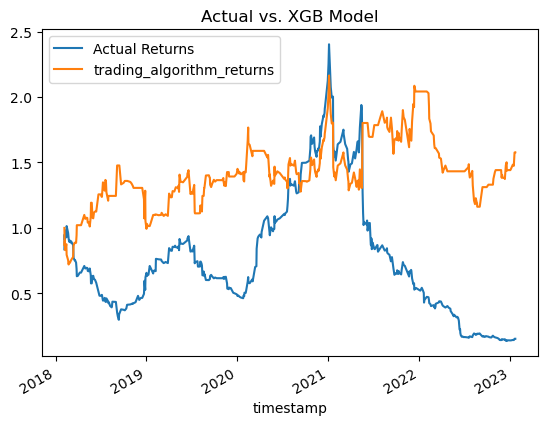

In [76]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["Actual Returns", "trading_algorithm_returns"]]).cumprod().plot(title= "Actual vs. XGB Model")


# Alpaca Markets

In [77]:
# Initial imports
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
import datetime as dt
import pandas_ta as pa

# Load .env environment variables
load_dotenv()

True

In [78]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [79]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url,
    api_version='v2')



In [80]:
# Date Variables
start_date = dt.date.today() - dt.timedelta(days = 20)
end_date = dt.date.today() + dt.timedelta(days = 2)

In [81]:
# Get current price and RSI information. Convert it into a dataframe and add Returns

def get_current_data():

    # Set the tickers
    tickers = ['ETHUSD']
    
    timeframe = "1Day"

    # Get current closing prices for ETHUSD
    df_portfolio = alpaca.get_crypto_bars(
        tickers,
        timeframe,
        start = start_date,
        end = end_date
    ).df
    #drop columns
    df_portfolio = df_portfolio.drop(['exchange','open','high', 'low','volume','trade_count','vwap', 'symbol'], axis = 1)
    
    #aggregate the close column
    df_portfolio = df_portfolio.resample('1D').agg(['first'])
    df_portfolio.columns = df_portfolio.columns.droplevel()
    df_portfolio.rename(columns = {'first':'Close'}, inplace = True)

    # RSI data
    df_portfolio['RSI'] = pa.rsi(df_portfolio['Close'], length=16)

   
    #calucate the returns
    df_portfolio['change'] = df_portfolio['Close'].pct_change()
    
    # fill in na with 0
    df_portfolio.fillna(0, inplace=True)

    #change to date index
    df_portfolio.index =  df_portfolio.index.date

    return df_portfolio

df= get_current_data()


In [82]:
# Get Fear and Greed data

r = requests.get('https://api.alternative.me/fng/?limit=0')

fg_df = pd.DataFrame(r.json()['data'])

    # convert 'value' to int
fg_df.value = fg_df.value.astype(int)

    # convert time format to datetime
fg_df.timestamp = pd.to_datetime(fg_df.timestamp, unit='s' )

    # set date as index
fg_df.set_index('timestamp', inplace=True)

    # drop all columns except 'value'
fg_df = fg_df.drop(['value_classification', 'time_until_update'], axis=1)

    # convert date format to match 'df close'
fg_df.index = pd.to_datetime(fg_df.index).tz_localize('Etc/UCT')

fg_df.index =  fg_df.index.date
    
# combine price/RSI fear and greed to df
df = df.join(fg_df)

df


,Close,RSI,change,value
2023-01-26,1582.76,0.000000,0.000000,54
2023-01-27,1600.08,0.000000,0.010943,55
2023-01-28,1597.85,0.000000,-0.001394,52
2023-01-29,1636.43,0.000000,0.024145,55
2023-01-30,1562.29,0.000000,-0.045306,61
2023-01-31,1583.01,0.000000,0.013263,51
2023-02-01,1670.43,0.000000,0.055224,56
2023-02-02,1644.66,0.000000,-0.015427,60
2023-02-03,1651.42,0.000000,0.004110,60
2023-02-04,1667.89,0.000000,0.009973,58


In [83]:
# Re-run the model with new set of data
from sklearn.pipeline import make_pipeline

# Make Pipeline
pipe = make_pipeline(full_processor, xgb_cl)

# Identify the features
X_new = df

# Predict new data set
target = pipe.predict(X_new)
target


array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1],
      dtype=int64)

In [84]:
# Check Whether Account Currently Holds Symbol
def check_positions(symbol):
    positions = alpaca.list_positions()
    for p in positions:
        if p.symbol == symbol:
            return float(p.qty)
    return 0



In [85]:
# Execute Trades
ticker = 'ETHUSD'
exist_position = check_positions(ticker)
account = alpaca.get_account()

# No existing position & short sell asset
if exist_position <= 0 and target[-1] == 2:

 # Submit a market order to open a short position of one share
    order = alpaca.submit_order(ticker, qty = 1, side= OrderSide.SELL, type ='market', time_in_force="gtc")
    message = f'Symbol: {ticker} | Side: Short Sell | Balance: {account.cash} '
    print(message)

# Sell all positions
elif exist_position > 0 and target[-1] == 2:
    position = alpaca.get_position(ticker)
    order = alpaca.submit_order(ticker, qty = position.qty, side= 'sell', type ='market', time_in_force="gtc")
    message = f'Symbol: {ticker} | Side: Sell | Balance: ${account.cash} '
    print(message)

# Buy when we don't have existing positon
elif exist_position == 0 and target[-1] == 1:
    order = alpaca.submit_order(ticker, side='buy', type = 'market', qty = 1, time_in_force="gtc")
    message = f'Symbol: {ticker} | Side: Buy | Balance: ${account.cash} '
    print(message)

# Buy when we have existing position
elif exist_position > 0 and target[-1] == 1:
    position = alpaca.get_position(ticker)

    if float(position.qty) < 0:
        # close out short sell positions and buy one more
        exist_position = abs(float(position.qty)) + 1
        order = alpaca.submit_order(ticker, side='buy', type = 'market', qty = exist_position, time_in_force="gtc")
        message = f'Symbol: {ticker} | Side: Buy | Balance: ${account.cash}'
        print(message)
    else:
        order = alpaca.submit_order(ticker, side='buy', type = 'market', qty = 1, time_in_force="gtc")
        message = f'Symbol: {ticker} | Side: Buy | Balance: ${account.cash}'
        print(message)

# Hold asset
elif target[-1] == 0:
    message = f'Symbol: {ticker} | Side: Holding | Balance: ${account.cash}'
    print(message)

Symbol: ETHUSD | Side: Buy | Balance: $101317.49743552


In [86]:
#close = alpaca.close_all_positions()

In [87]:
g= alpaca.get_activities()
g

[AccountActivity({   'activity_type': 'FILL',
     'cum_qty': '1',
     'id': '20230216004929211::f37fd503-d5e2-483f-9367-920d00e1f48d',
     'leaves_qty': '0',
     'order_id': 'e3fb616c-ed52-4a71-987d-c263941683dc',
     'order_status': 'filled',
     'price': '1694.27616',
     'qty': '1',
     'side': 'buy',
     'symbol': 'ETH/USD',
     'transaction_time': '2023-02-16T05:49:29.211528Z',
     'type': 'fill'}),
 AccountActivity({   'activity_type': 'FILL',
     'cum_qty': '1',
     'id': '20230216004631604::e21b6b95-7ea1-43d6-8b12-89f1d23e8afd',
     'leaves_qty': '0',
     'order_id': '109d09fc-9834-4cd4-9757-9983487869a3',
     'order_status': 'filled',
     'price': '1694.8212',
     'qty': '1',
     'side': 'buy',
     'symbol': 'ETH/USD',
     'transaction_time': '2023-02-16T05:46:31.604861Z',
     'type': 'fill'}),
 AccountActivity({   'activity_type': 'FILL',
     'cum_qty': '1',
     'id': '20230215194208771::0eda7270-755b-4dbb-a527-1e91052fefa4',
     'leaves_qty': '0',
  

In [88]:
# Obtain account information
account = alpaca.get_portfolio_history()
print (f'Starting Portfolio(As of 1/26/23): ${account.equity[0]}')
print (f'Current Portfolio: ${account.equity[-1]}')
print (f'Difference of ${round(account.equity[-1] - account.equity[0],2)}')
account = alpaca.get_account()
print (f'Cash balance: ${round(float(account.cash),2)}')
account = alpaca.get_position(ticker)

print (f'Asset: {account.symbol} | Qty: {account.qty} | Worth: ${round(float(account.qty) * float(account.current_price),2)}')

Starting Portfolio(As of 1/26/23): $100000
Current Portfolio: $111005.35610154436
Difference of $11005.36
Cash balance: $99623.22
Asset: ETHUSD | Qty: 6.9825 | Worth: $11824.17
